In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [24]:
path = 'C:/Users/Bhoomeendra/SMAI/faces'
imgsize = 64*64
nameImg = {} # A :[ imga1 ,img]
for img in os.listdir(path):
    finalPath = os.path.join(path,img)
    cimg = cv2.imread(finalPath,-1)
    name = img[:-9]
    
    if(nameImg.get(name) == None):
        nameImg[name] = [cimg]
    else:
        nameImg[name].append(cimg)
print(len(nameImg))

5749


In [57]:
count = np.zeros((1000))
for key, value in nameImg.items():
    count[len(value)]=1+ count[len(value)]

In [58]:
# No of people with more than 20 or more photos 
print(np.sum(count[20:]))

62.0


In [59]:

testImgNo = 19
# Nomalized but not mean centred
trainImg = {}
testImg  = {}# threshold for test
for key, value in nameImg.items():
    if(len(value)>testImgNo):
        trainImg[key] = value[:testImgNo]
        testImg[key]  = [value[testImgNo]]

62


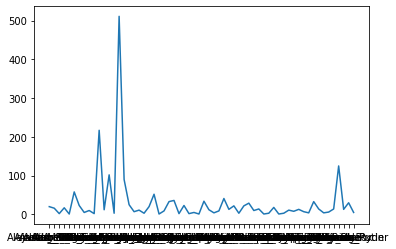

In [86]:
label = list()
y = list()
for key, value in nameImg.items():
    if(len(value)>testImgNo):
        label.append(key)
        y.append(len(value[testImgNo:]))
print(len(y))
plt.plot(label,y)
plt.show()

In [120]:
#Calculating Matrix A
NSA = np.zeros((len(trainImg)*testImgNo,imgsize))
print("Matrix Size: ",NSA.shape)
j=0

for key, value in trainImg.items():
    for face in value:
        flt = face.flatten()
        for k in range(len(flt)):
            NSA[j][k]=flt[k]
        j=j+1
j=0

testMatrix = np.zeros((len(testImg),imgsize))
for key,value in testImg.items():
    for face in value:
        flt = face.flatten()
        for k in range(len(flt)):
            testMatrix[j][k]=flt[k]
        j=j+1
print("Test Size: ",testMatrix.shape)

Matrix Size:  (1178, 4096)
Test Size:  (62, 4096)


In [121]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(NSA)
A=scaler.transform(NSA)
test = scaler.transform(testMatrix)

In [122]:
print((1178)**(1/2))

34.322004603461025


In [123]:
from sklearn.decomposition import PCA
pca=PCA(n_components=100)
pca.fit(A)
A_pca=pca.transform(A)
test_pca=pca.transform(test)

In [124]:
j=0
correct=0
incorrect=0
for t in test_pca:
    minDist= 35
    i=0
    ans = -1
    for k in A_pca:
        dist = np.linalg.norm(t -k)
        if(dist<minDist):
            ans=i
            minDist=dist
        i=i+1
    if(j==ans//19):
        correct= correct+1
    else:
        incorrect = incorrect+1
    #print(j,ans//19)
    j=j+1
print("Correct : ",correct)
print("Incorrect : ",incorrect)
print("Total : ",correct+incorrect)

Correct :  1
Incorrect :  61
Total :  62


In [98]:
A = A.T
print(A.shape)

(4096, 1178)


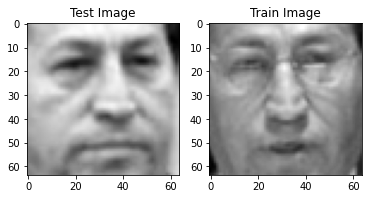

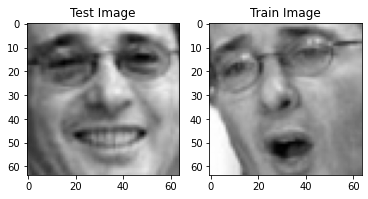

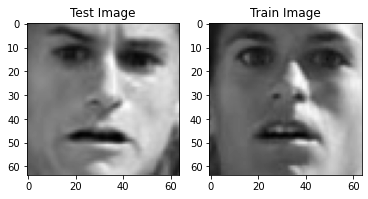

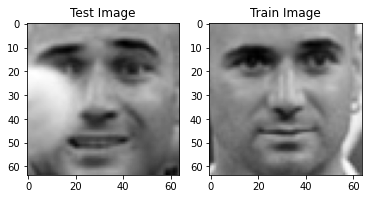

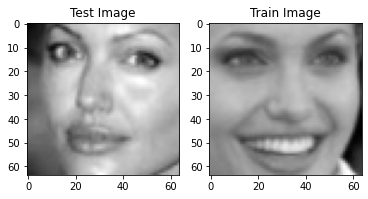

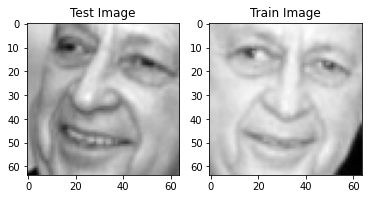

In [99]:
count = 0
for key, value in trainImg.items():
    fig ,axs = plt.subplots(1,2,figsize=(6,3))
    axs[0].set_title("Test Image")
    axs[0].imshow(testImg[key][0],cmap='gray')
    axs[1].set_title("Train Image")
    axs[1].imshow(value[0],cmap = 'gray')
    plt.show()
    count=1+count
    if(count>5):
        break    
    

In [100]:
#Covariance Matrix
Cov = np.matmul(A.T,A)

In [101]:
print(Cov.shape)

(1178, 1178)


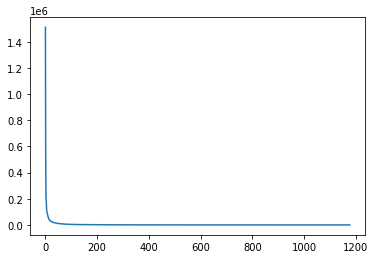

In [102]:
#Calculating Eigen Vector and Value
w , v = np.linalg.eig(Cov)

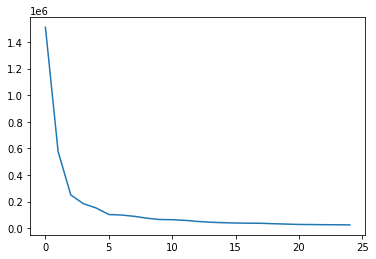

In [110]:
arr = np.arange(w.shape[0])
plt.plot(w[:25])

In [118]:
print(w[100])

4005.347517302058


In [47]:
#Sorting eVal_eganVec
eVal_eganVec = list()
for i in range(len(trainImg)*5):
    eVal_eganVec.append([w[i] , v[:,i]])
sortedeeV =sorted(eVal_eganVec, key=lambda x: x[0],reverse=True)

In [48]:
#Converting eigenvector from m x1  to n^2 x 1
eigenVector = list()
for i in sortedeeV:
    eigenVector.append(np.matmul(A,i[1]))

In [49]:
print(eigenVector[0].shape)
print(len(eigenVector))

(4096,)
310


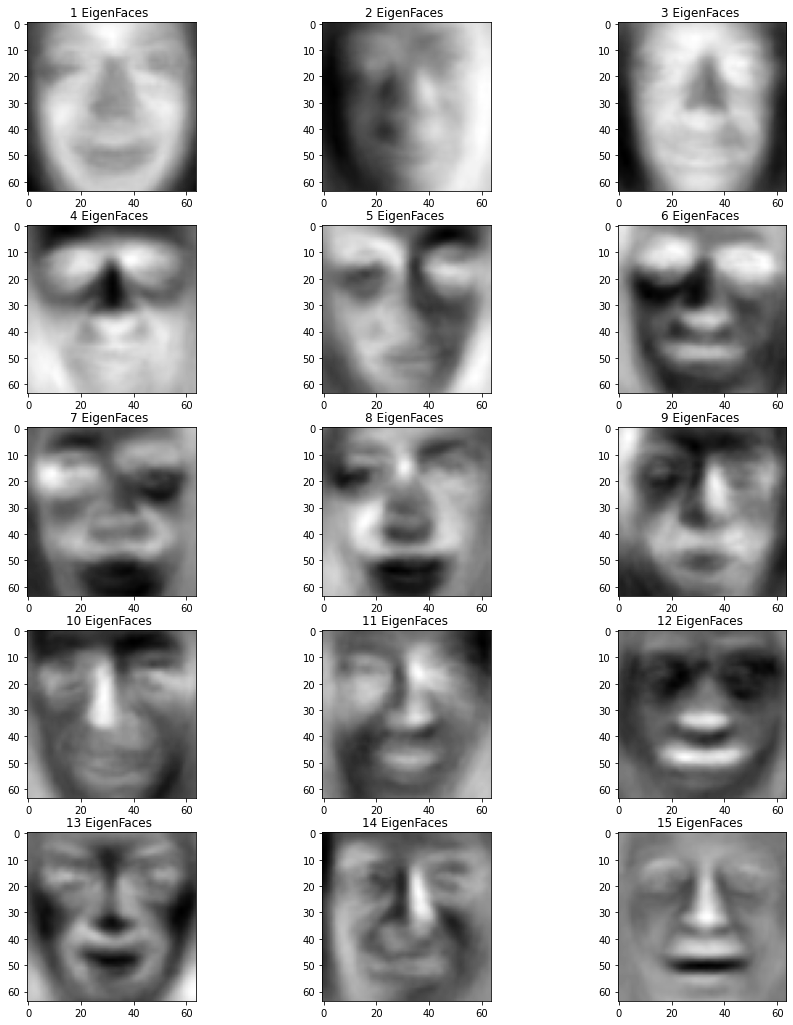

In [50]:
fig ,axs = plt.subplots(5,3,figsize=(15,18))
for i in range(5):
    for j in range(3):
        axs[i,j].set_title(str(3*i+j+1) + " EigenFaces ")
        axs[i,j].imshow(eigenVector[3*i+j].reshape(64,64),cmap = 'gray')

In [51]:
def eigenRepresentation(img,eigenVector,dim = 50):
    imgReresentation = np.zeros((dim))
    for i in range(dim):
        imgReresentation[i] = np.dot(img,eigenVector[i])
    return imgReresentation/(imgsize)

# No of eigenFaces used to make face-space
sz=len(eigenVector)

# Faces From which we learned eigenVectors
knowFaces = {}
for key, value in trainImg.items():
    knowFaces[key] = list()
    for face in value:
        meanc = face.flatten()
        meanc = (meanc - avgFace)/stdFace
        knowFaces[key].append(eigenRepresentation(meanc,eigenVector,sz))

unknowFaces = {}
for key, value in testImg.items():
    unknowFaces[key] = list()
    for face in value:
        meanc = face.flatten()
        meanc = (meanc - avgFace)/stdFace
        unknowFaces[key].append(eigenRepresentation(meanc,eigenVector,sz))

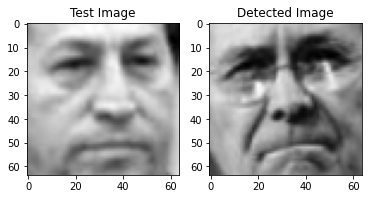

2.7694748930601993
Incorrect


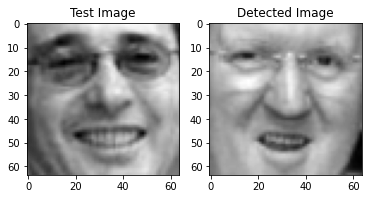

2.803517832045848
Incorrect


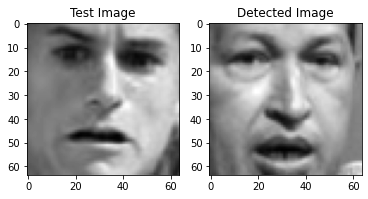

3.50251478726871
Incorrect


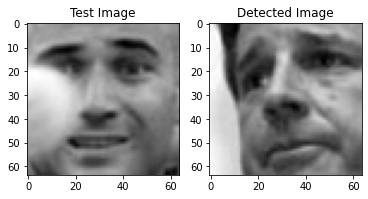

3.114946971084529
Incorrect


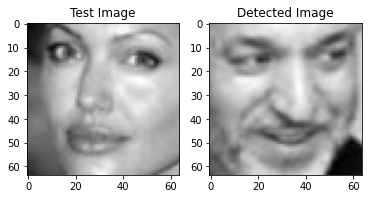

2.1433747859811283
Incorrect


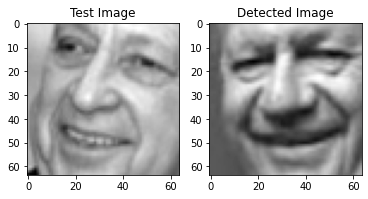

2.577711023089783
Incorrect


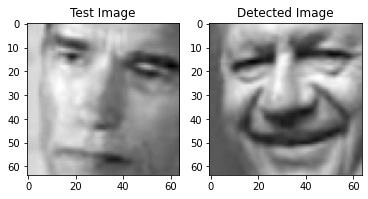

2.3724626918108345
Incorrect


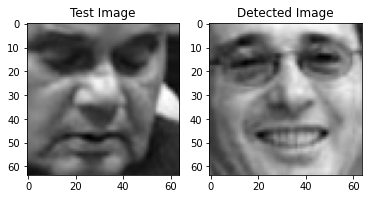

2.678210593217412
Incorrect


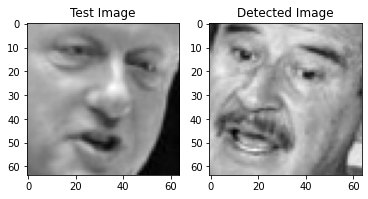

2.9552246349316906
Incorrect


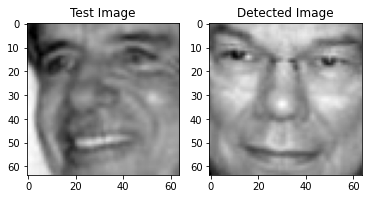

2.392794047131625
Incorrect


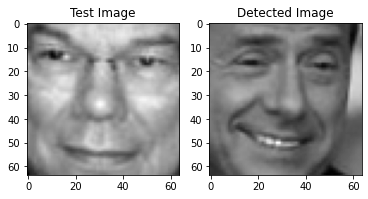

1.487060847996496
Incorrect


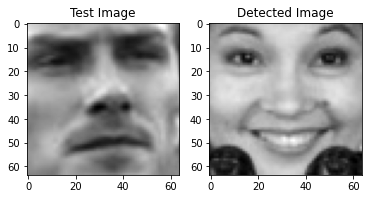

2.77663229657897
Incorrect


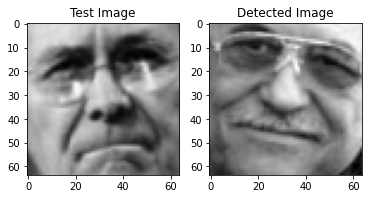

2.8530937474925224
Incorrect


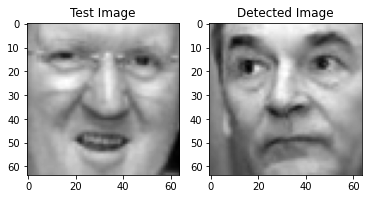

2.6146031475674154
Incorrect


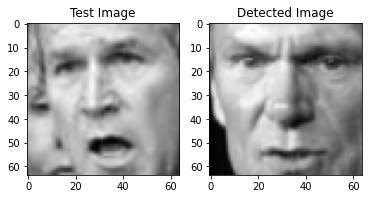

2.113747967450878
Incorrect


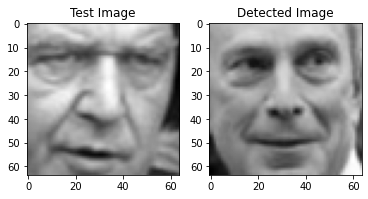

2.6867032198110037
Incorrect


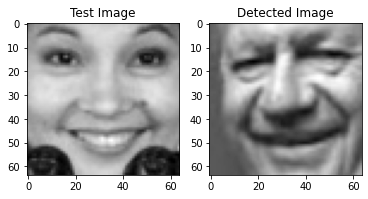

2.8616696296250725
Incorrect


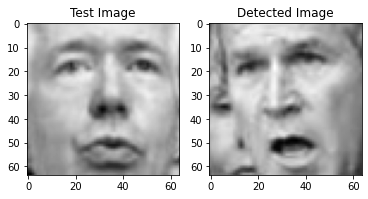

2.770653892855982
Incorrect


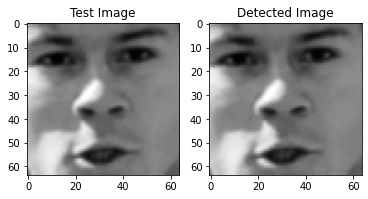

2.7672121416398805
Correct


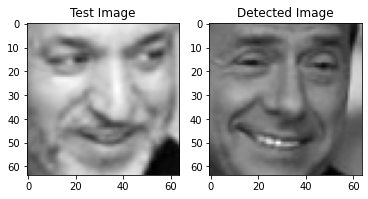

2.665894296184669
Incorrect


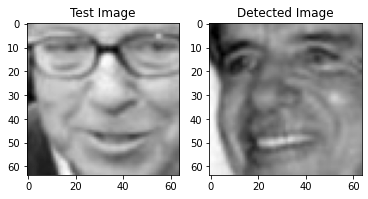

2.7286165791447337
Incorrect


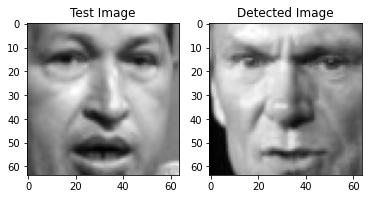

2.684201529607038
Incorrect


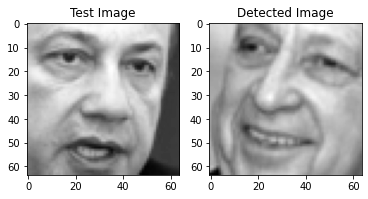

3.058548907961968
Incorrect


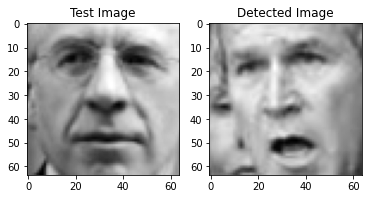

3.0301154312679213
Incorrect


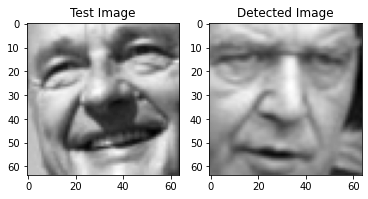

4.368803538473224
Incorrect


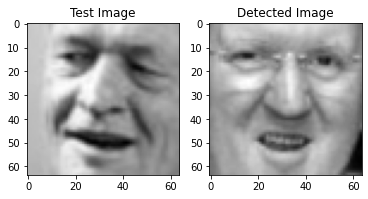

4.409588297416214
Incorrect


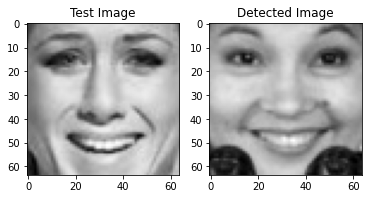

3.20333797252385
Incorrect


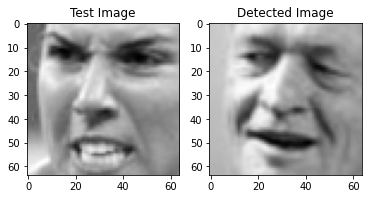

2.8261760002645406
Incorrect


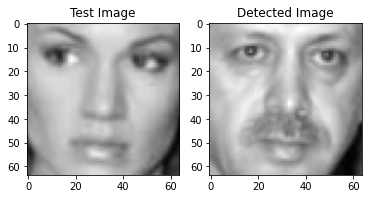

2.2840676346725033
Incorrect


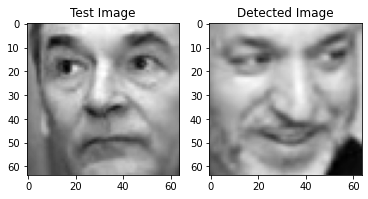

2.4920644676167876
Incorrect


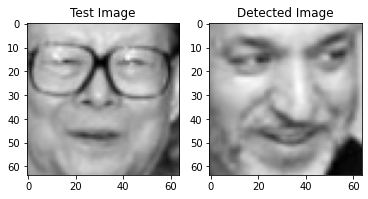

2.553968993362603
Incorrect


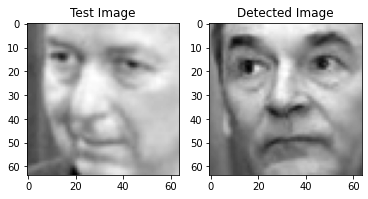

2.3824699527454922
Incorrect


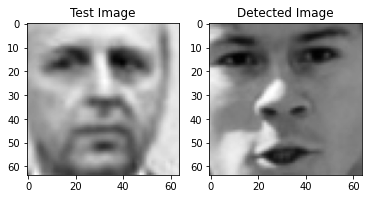

3.0166304436309206
Incorrect


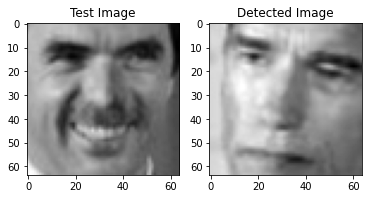

2.8711314102227594
Incorrect


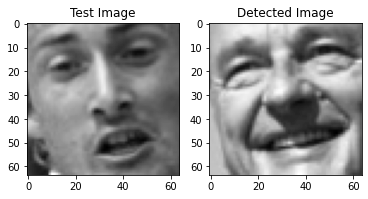

2.563090412683842
Incorrect


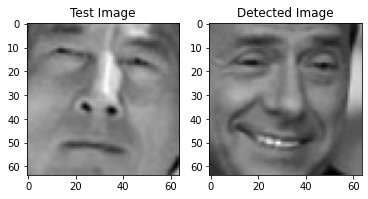

2.3774913867897634
Incorrect


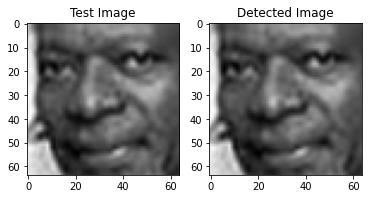

2.822756977205365
Correct


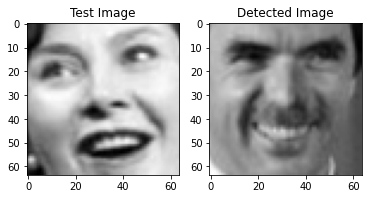

3.1591753675884986
Incorrect


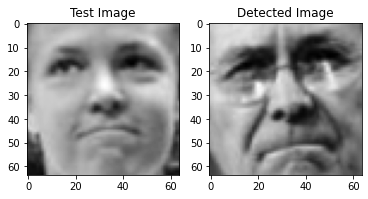

1.9352780603761905
Incorrect


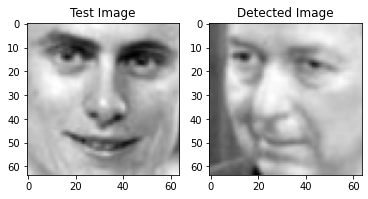

2.7095324814456645
Incorrect


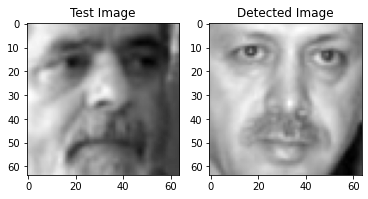

4.749895902742089
Incorrect


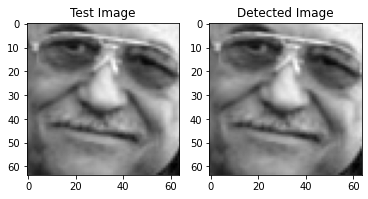

2.9783943004331714
Correct


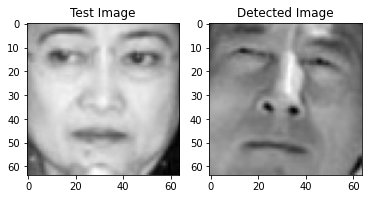

2.367799471208745
Incorrect


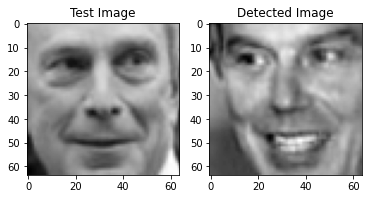

2.6406454039645886
Incorrect


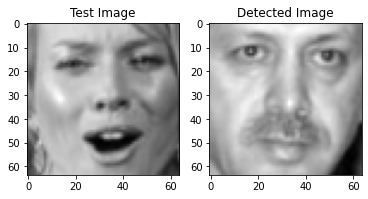

3.076739103854926
Incorrect


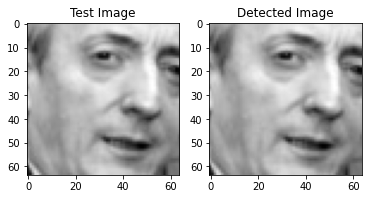

2.717528575367497
Correct


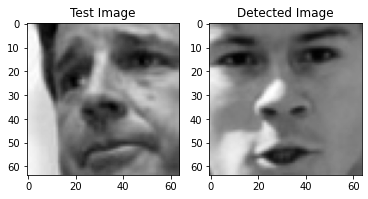

3.629827843635603
Incorrect


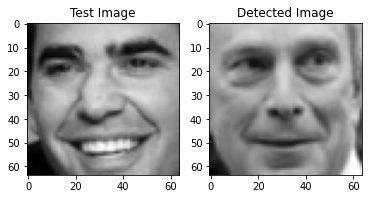

3.0061724525190514
Incorrect


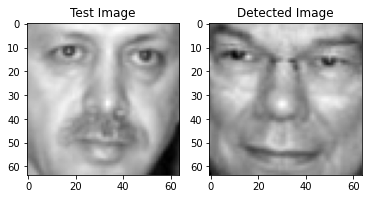

2.4150369956889457
Incorrect


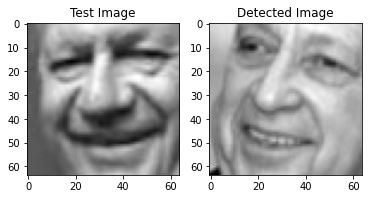

2.455619622572302
Incorrect


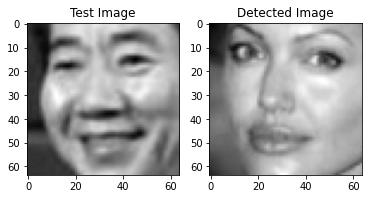

2.777014679694767
Incorrect


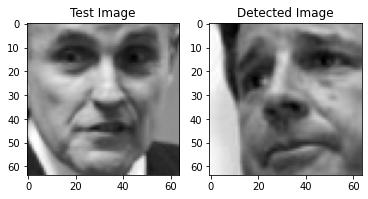

3.0042693565715397
Incorrect


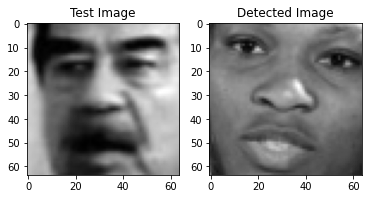

6.162997438463501
Incorrect


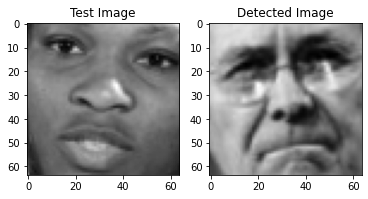

2.522455768365262
Incorrect


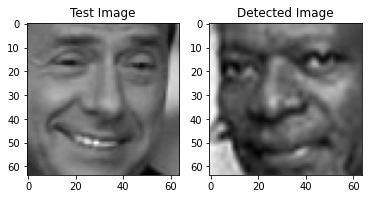

1.7732139850265407
Incorrect


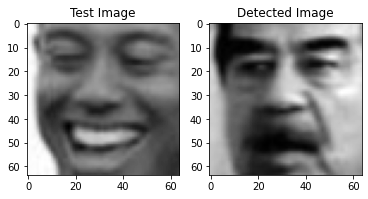

2.8833846019361458
Incorrect


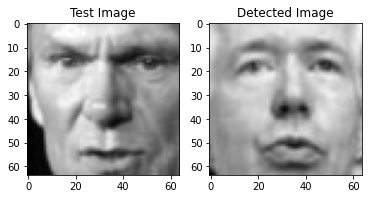

4.097210179438166
Incorrect


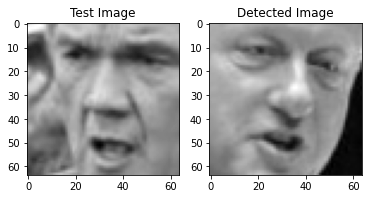

2.10264130604844
Incorrect


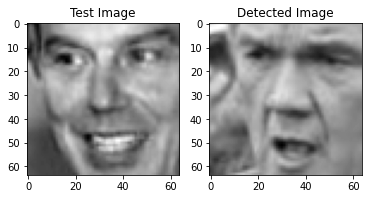

2.224303691054384
Incorrect


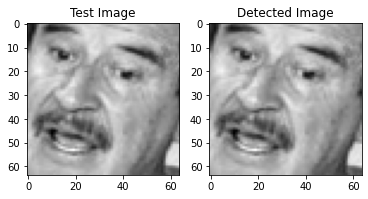

2.184770430868232
Correct


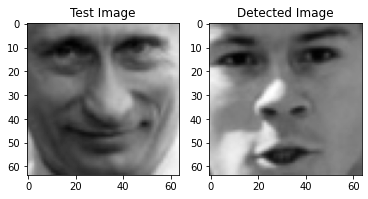

3.1811787230080983
Incorrect


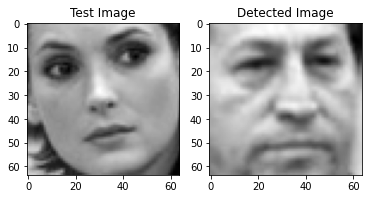

2.7502954681084844
Incorrect
Correct :  5
Incorrect :  57
Total :  62


In [56]:
# Testing Phase
correct = 0
incorrect =0
total=0
for key,value in unknowFaces.items():# A : [imga20]
    for puface in value:#pface = Projected unkown Face
        total+=1
        minDist = 1000
        ans = 'None'
        for tkey, tvalue in knowFaces.items():
            for pkface in tvalue:
                dist = np.linalg.norm(puface - pkface )#Euclidean distance
                #print(dist)
                if( dist < minDist):
                    minDist = dist
                    ans = tkey #imga18
        fig ,axs = plt.subplots(1,2,figsize=(6,3))
        axs[0].set_title("Test Image")
        axs[0].imshow(testImg[key][0],cmap='gray')
        axs[1].set_title("Detected Image")
        axs[1].imshow(testImg[ans][0],cmap = 'gray')
        plt.show()
        print(minDist)
        if(ans == key):
            correct=correct+1
            print("Correct")
            
        else:
            incorrect=incorrect+1
            print("Incorrect")
print("Correct : ",correct)
print("Incorrect : ",incorrect)
print("Total : ",correct+incorrect)


In [35]:
print("Total : ",total)

Total :  1845
